### 3. Data analysis
1) Data importing, cleaning, etc.
2) Exploratory data analysis
3) Modelling the relationship

In [410]:
# Importing libraries and tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

#### 3.1 Data preprocessing

In [411]:
# Downloading the OHLC prices of S&P500 from Yahoo Finance
sp500 = yf.download("SPY", start="2014-01-01", end="2023-12-31")
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2014-01-02,149.840561,150.782601,149.480129,150.708867,119636900
2014-01-03,149.815994,150.397603,149.603017,150.094505,81390600
2014-01-06,149.381851,150.364840,149.152488,150.307505,108028200
2014-01-07,150.299240,150.553177,149.865087,149.979769,86144200
2014-01-08,150.332092,150.586030,149.816018,150.274745,96582300


In [412]:
# Calculating daily volatility using the Rogers-Satchell volatility estimator
log_HO = np.log(sp500[("High", "SPY")] / sp500[("Open", "SPY")])
log_HC = np.log(sp500[("High", "SPY")] / sp500[("Close", "SPY")])
log_LO = np.log(sp500[("Low", "SPY")] / sp500[("Open", "SPY")])
log_LC = np.log(sp500[("Low", "SPY")] / sp500[("Close", "SPY")])

rs_var_daily = log_HO * log_HC + log_LO * log_LC
sp500_vol = np.sqrt(rs_var_daily)

sp500_vol.head()

Date
2014-01-02    0.004773
2014-01-03    0.003533
2014-01-06    0.003789
2014-01-07    0.002942
2014-01-08    0.003742
dtype: float64

In [413]:
# Downloading the VIX index data
vix = yf.download("^VIX", start="2014-01-01", end="2023-12-31")
vix = vix[("Close", "^VIX")]
vix.head()

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    14.23
2014-01-03    13.76
2014-01-06    13.55
2014-01-07    12.92
2014-01-08    12.87
Name: (Close, ^VIX), dtype: float64

In [414]:
# Importing the Google SVI data
df = pd.read_csv("04_svi_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df.drop("2014-01-01", axis=0, inplace=True)
df.head()

,stock market crash,bear market,bull market,stock bubble,market volatility,S&P 500,recession,interest rates,inflation,financial crisis
date,,,,,,,,,,
2014-01-02,0.535109,1.200592,7.197500,11.80632,0.0,2.671864,1.447663,6.092228,4.996298,7.383395
2014-01-03,0.486463,0.820998,5.508821,0.00000,0.0,1.947291,1.358197,6.092228,4.996298,9.278279
2014-01-04,0.437817,1.074061,5.991301,0.00000,0.0,0.724573,1.313465,4.459012,2.132765,9.278279
2014-01-05,0.583756,0.251608,3.820141,0.00000,0.0,0.407572,1.760793,3.778505,2.610021,13.826002
2014-01-06,1.216158,0.820998,5.508821,0.00000,0.0,2.037862,2.208121,6.636634,7.382575,10.415210


In [415]:
# Keeping only Mon-Fri data
df = df[df.index.weekday < 5]
df.head()

,stock market crash,bear market,bull market,stock bubble,market volatility,S&P 500,recession,interest rates,inflation,financial crisis
date,,,,,,,,,,
2014-01-02,0.535109,1.200592,7.197500,11.806320,0.0,2.671864,1.447663,6.092228,4.996298,7.383395
2014-01-03,0.486463,0.820998,5.508821,0.000000,0.0,1.947291,1.358197,6.092228,4.996298,9.278279
2014-01-06,1.216158,0.820998,5.508821,0.000000,0.0,2.037862,2.208121,6.636634,7.382575,10.415210
2014-01-07,1.362097,0.631201,5.750061,11.384665,0.0,2.037862,2.342320,6.772735,8.098458,13.826002
2014-01-08,1.556682,1.327123,7.921220,14.125418,0.0,1.902005,2.252854,6.092228,7.859830,11.931117


In [416]:
# Importing the headlines sentiment data and again keeping only Mon-Fri
df_sent = pd.read_csv("06_headlines_data.csv")
df_sent["Date"] = pd.to_datetime(df_sent["Date"])
df_sent = df_sent.set_index("Date")
df_sent = df_sent.groupby("Date")[["positive", "neutral", "negative"]].sum()
sentiment = df_sent["positive"] - df_sent["negative"]
sentiment = sentiment[sentiment.index.weekday < 5]

#sentiment.head()

In [417]:
# Joining together the Google SVI data, headlines sentiment data, S&P volatility and the VIX index
df["S&P volatility"] = sp500_vol
df["VIX"] = vix
df["sentiment"] = sentiment
df.dropna(inplace=True)
df.head()

,stock market crash,bear market,bull market,stock bubble,market volatility,S&P 500,recession,interest rates,inflation,financial crisis,S&P volatility,VIX,sentiment
date,,,,,,,,,,,,,
2014-01-02,0.535109,1.200592,7.197500,11.806320,0.0,2.671864,1.447663,6.092228,4.996298,7.383395,0.004773,14.23,3.024111
2014-01-03,0.486463,0.820998,5.508821,0.000000,0.0,1.947291,1.358197,6.092228,4.996298,9.278279,0.003533,13.76,0.997873
2014-01-06,1.216158,0.820998,5.508821,0.000000,0.0,2.037862,2.208121,6.636634,7.382575,10.415210,0.003789,13.55,2.962439
2014-01-07,1.362097,0.631201,5.750061,11.384665,0.0,2.037862,2.342320,6.772735,8.098458,13.826002,0.002942,12.92,3.954297
2014-01-08,1.556682,1.327123,7.921220,14.125418,0.0,1.902005,2.252854,6.092228,7.859830,11.931117,0.003742,12.87,1.999975


In [418]:
# Creating a dataframe with lagged values of features and next day volatility
df_model = pd.DataFrame(df["S&P volatility"])

for col in df.columns:
    if col != "S&P volatility":
        df_model[f"{col}_lag1"] = df[col].shift(1)

df_model.dropna(inplace=True)
df_model.head()

,S&P volatility,stock market crash_lag1,bear market_lag1,bull market_lag1,stock bubble_lag1,market volatility_lag1,S&P 500_lag1,recession_lag1,interest rates_lag1,inflation_lag1,financial crisis_lag1,VIX_lag1,sentiment_lag1
date,,,,,,,,,,,,,
2014-01-03,0.003533,0.535109,1.200592,7.197500,11.806320,0.0,2.671864,1.447663,6.092228,4.996298,7.383395,14.23,3.024111
2014-01-06,0.003789,0.486463,0.820998,5.508821,0.000000,0.0,1.947291,1.358197,6.092228,4.996298,9.278279,13.76,0.997873
2014-01-07,0.002942,1.216158,0.820998,5.508821,0.000000,0.0,2.037862,2.208121,6.636634,7.382575,10.415210,13.55,2.962439
2014-01-08,0.003742,1.362097,0.631201,5.750061,11.384665,0.0,2.037862,2.342320,6.772735,8.098458,13.826002,12.92,3.954297
2014-01-09,0.005747,1.556682,1.327123,7.921220,14.125418,0.0,1.902005,2.252854,6.092228,7.859830,11.931117,12.87,1.999975


In [419]:
df_model.shape

(2437, 13)

#### 3.2 Exploratory data analysis
- Plotting
- Correlation matrix
- Granger causality

In [420]:
# Normalizing the data for plotting
df_norm = pd.DataFrame()

for col in df.columns:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

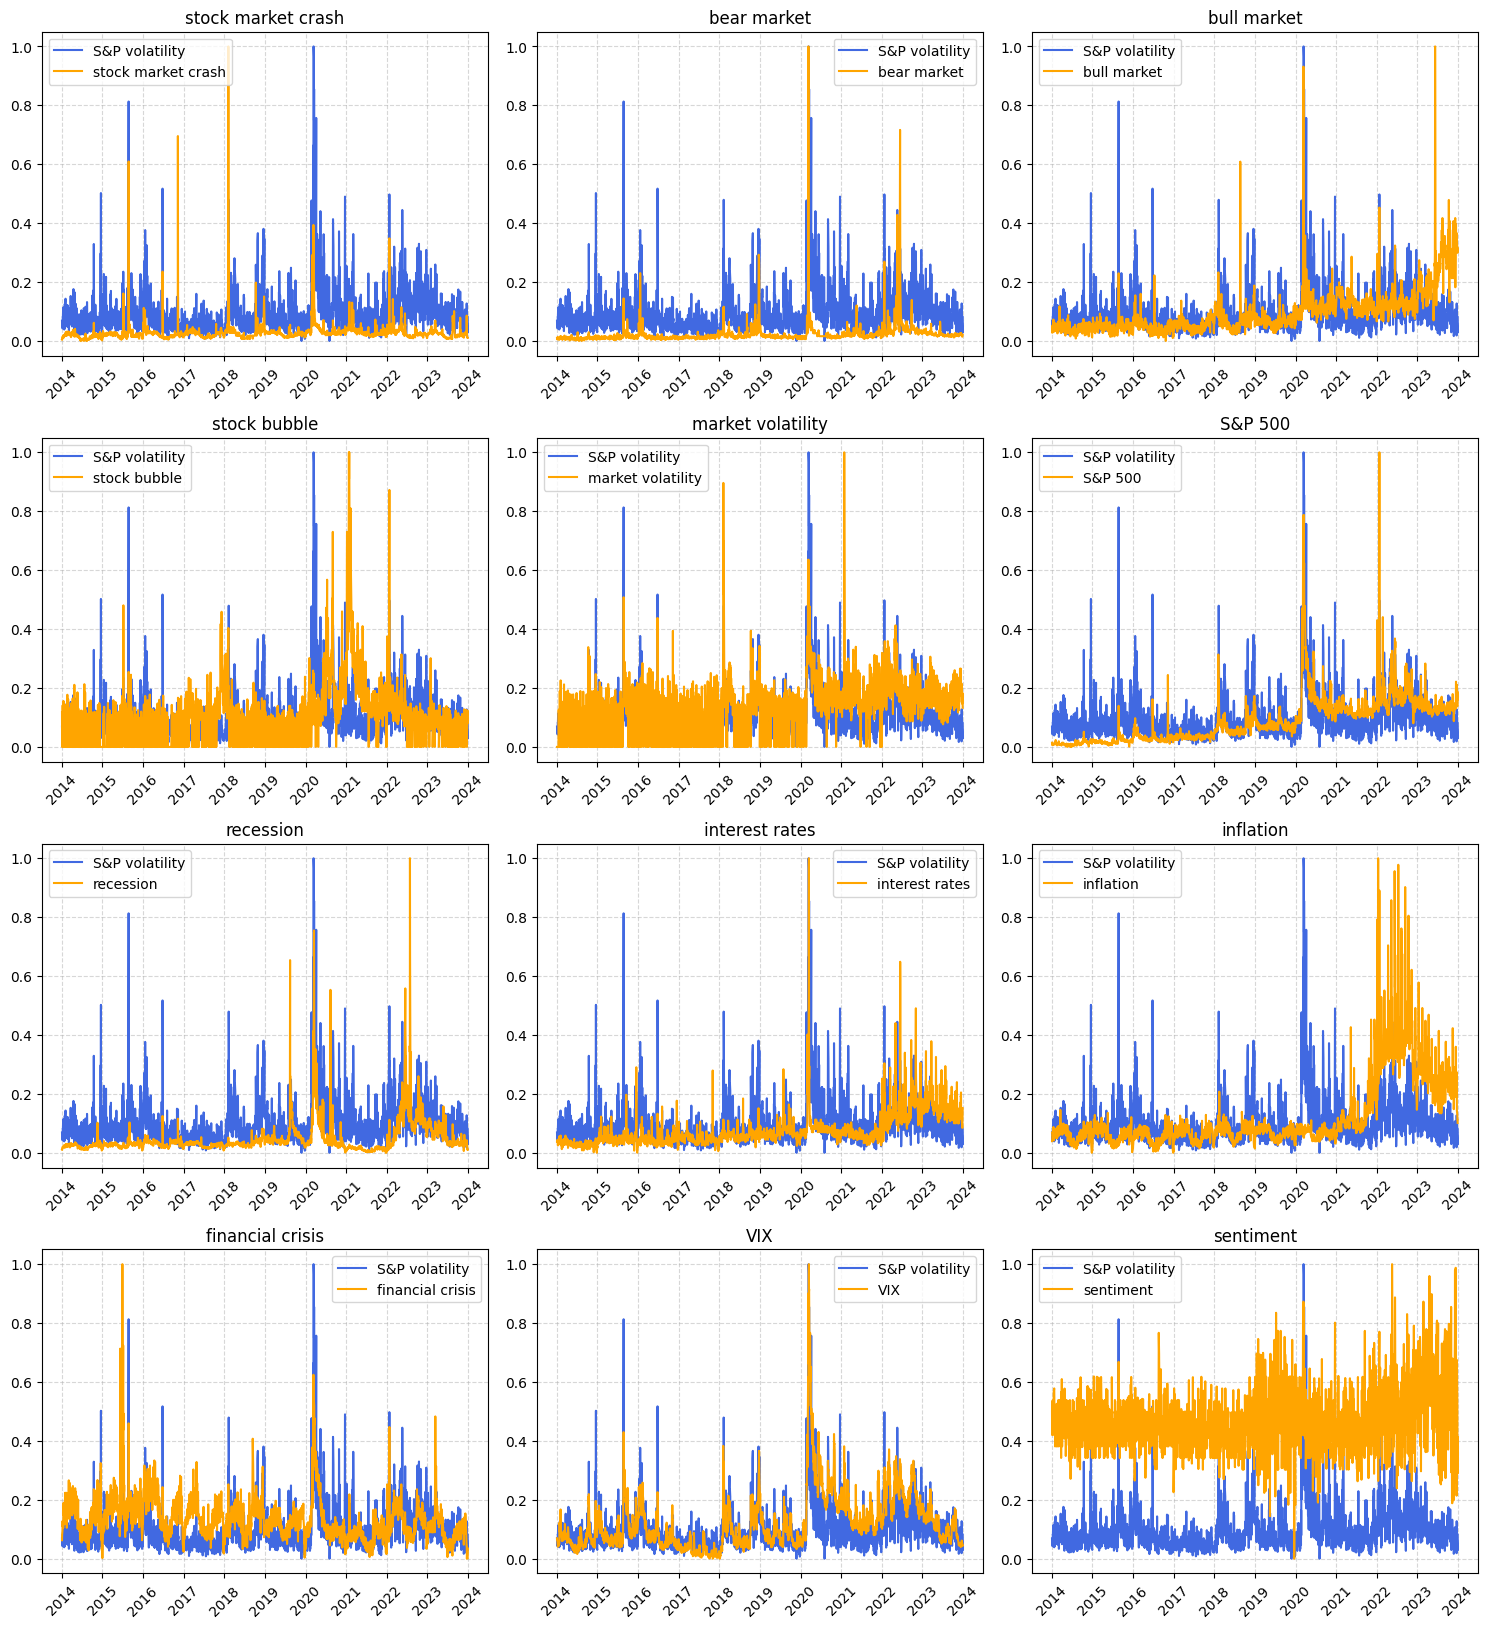

In [421]:
# Plotting each time series with S&P 500 volatility
cols = [col for col in df_norm.columns if col != "S&P volatility"]

rows = 5
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
axes = axes.flatten()

vol = df_norm["S&P volatility"]

for i, col in enumerate(cols):
    ax = axes[i]
    ax.plot(vol, label="S&P volatility", color="royalblue")
    ax.plot(df_norm[col], label=col, color="orange")
    ax.set_title(col)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

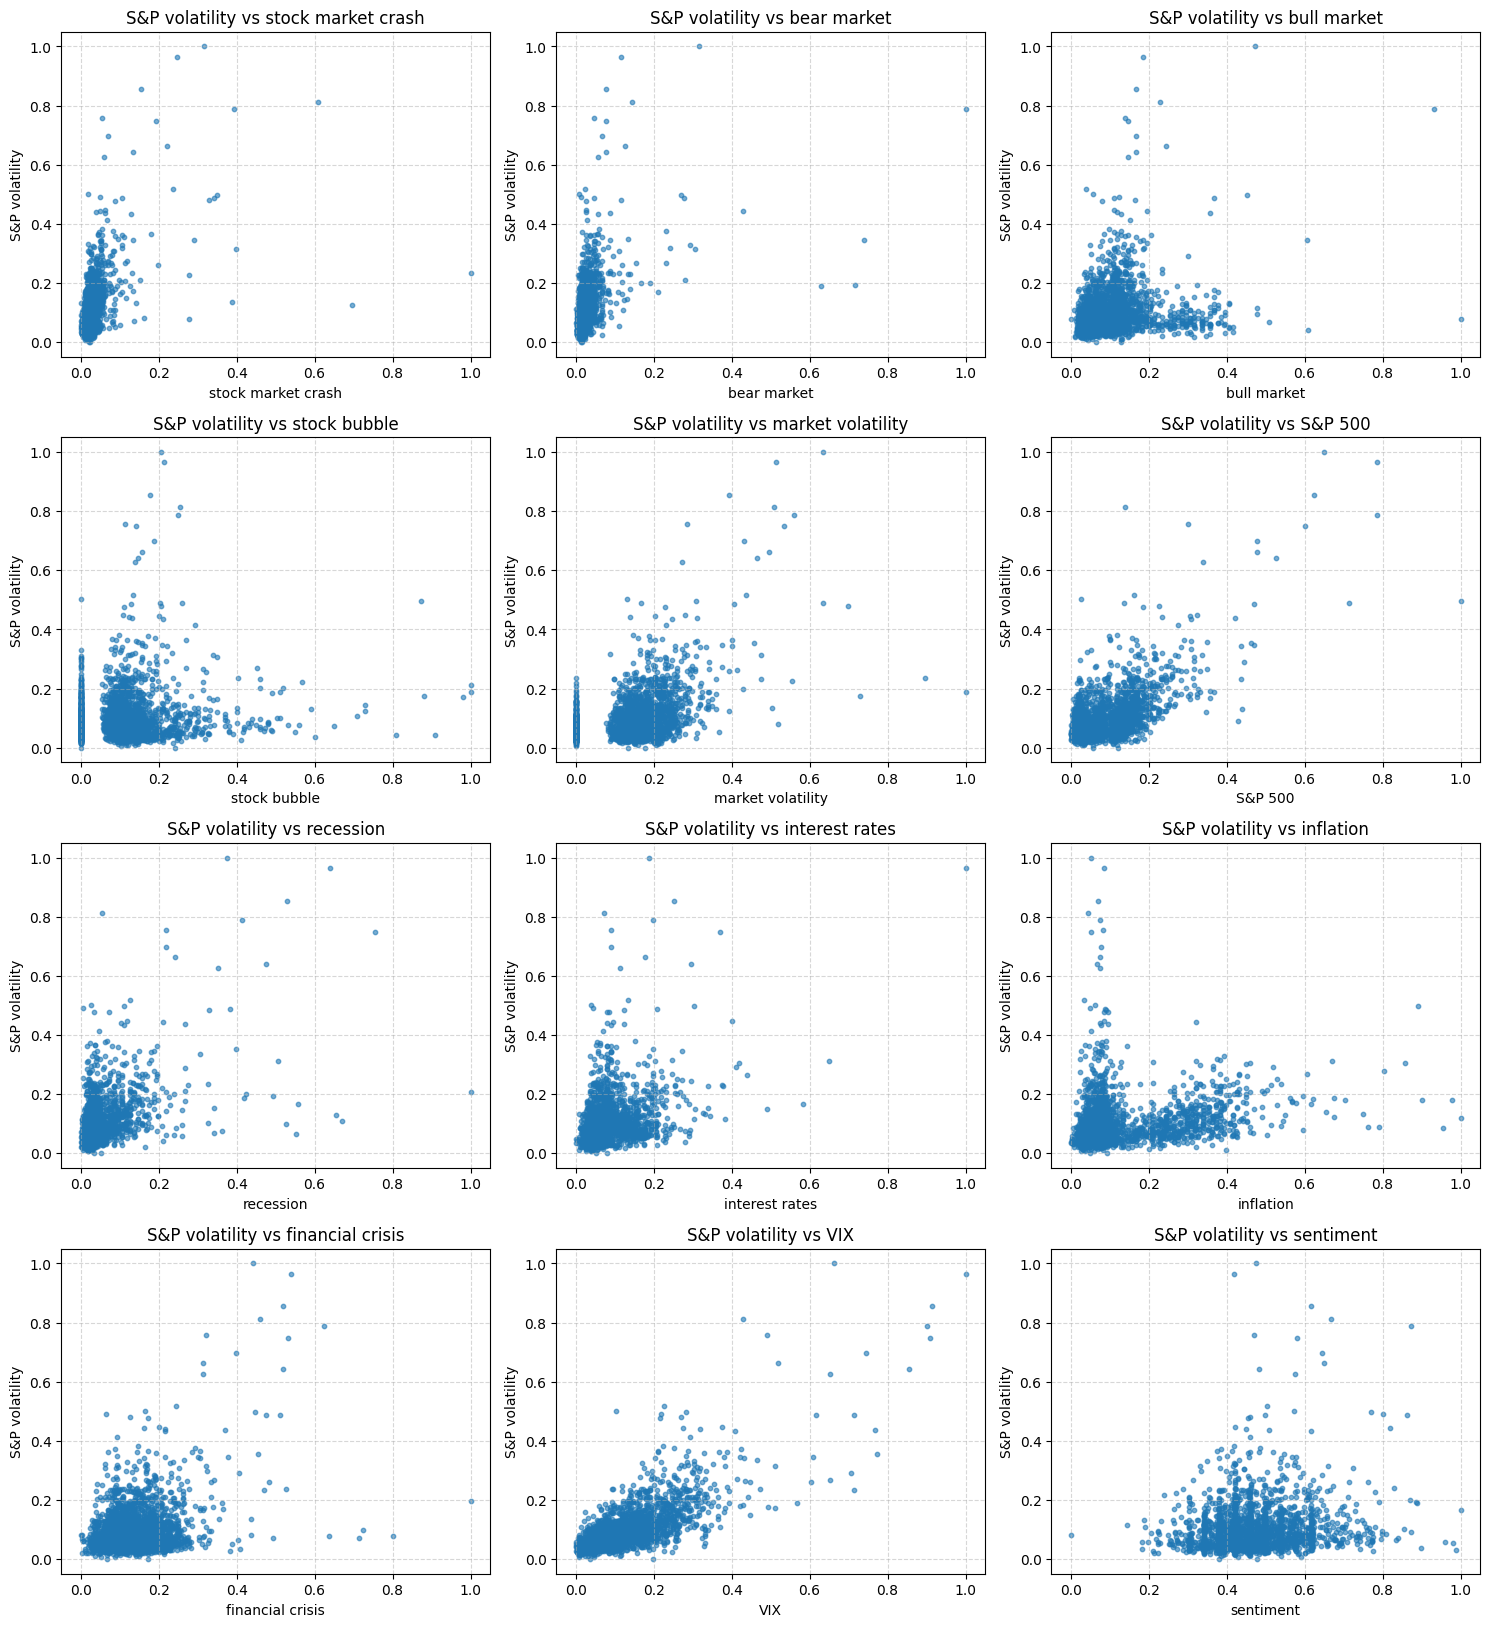

In [422]:
# Plotting the variables against S&P 500 (X-Y plot)
cols = [c for c in df_norm.columns if c != "S&P volatility"]

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()
y = df_norm["S&P volatility"]

for i, col in enumerate(cols):
    axes[i].scatter(df_norm[col], y, s=10, alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("S&P volatility")
    axes[i].set_title(f"S&P volatility vs {col}")
    axes[i].grid(True, linestyle="--", alpha=0.5)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

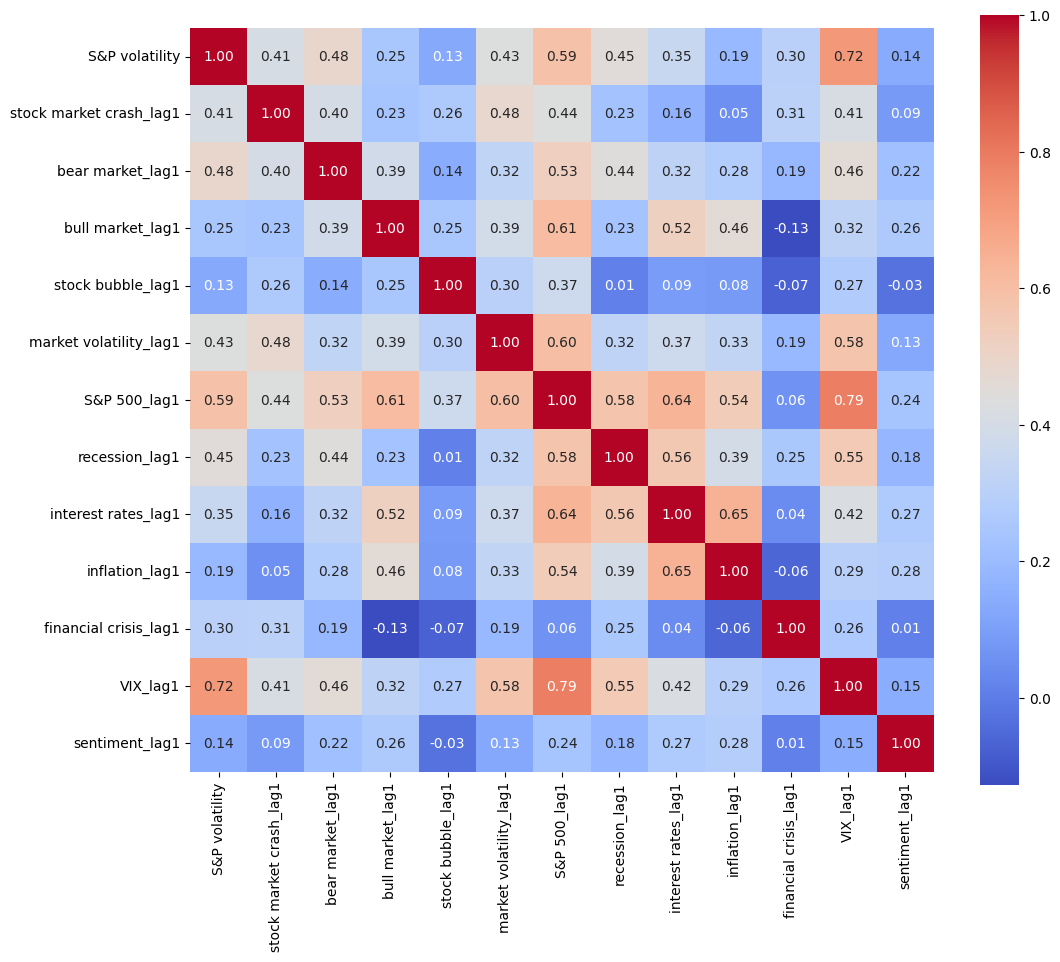

In [423]:
# Correlation matrix
corr_matrix = df_model.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

In [424]:
# P-values of the pearson correlation and defining the insignificant relationships
cols = df_model.columns
n = len(cols)
corr_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
pval_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)

for i in range(n):
    for j in range(n):
        r, p = pearsonr(df_model.iloc[:, i], df_model.iloc[:, j])
        corr_matrix.iloc[i, j] = r
        pval_matrix.iloc[i, j] = p
print(pval_matrix["S&P volatility"].sort_values(ascending=True), "\n")
print("Insignificant p-values:\n", pval_matrix["S&P volatility"][pval_matrix["S&P volatility"] > 0.05].sort_values(ascending=False))

S&P volatility              0.000000e+00
VIX_lag1                    0.000000e+00
S&P 500_lag1               4.814639e-226
bear market_lag1           1.204370e-143
recession_lag1             9.964304e-124
market volatility_lag1     8.756963e-113
stock market crash_lag1     1.409313e-98
interest rates_lag1         1.094210e-71
financial crisis_lag1       5.717958e-52
bull market_lag1            8.972089e-35
inflation_lag1              8.721112e-22
sentiment_lag1              4.061494e-12
stock bubble_lag1           3.423224e-11
Name: S&P volatility, dtype: float64 

Insignificant p-values:
 Series([], Name: S&P volatility, dtype: float64)


In [425]:
# Granger causality
pvalues = {}

for col in df.columns:
    if col == "S&P volatility":
        continue
    data = df[["S&P volatility", col]].dropna()
    data.columns = ["y", "x"]
    test_result = grangercausalitytests(data, maxlag=1, verbose=False)
    pval = test_result[1][0]['ssr_chi2test'][1]
    pvalues[col] = pval

pval_series = pd.Series(pvalues).sort_values()
print(pval_series, "\n")

print("Insignificant p-values:\n", pval_series[pval_series > 0.05].sort_values(ascending=False))

VIX                   6.873814e-163
S&P 500                5.981402e-60
bear market            4.971736e-50
recession              2.216791e-28
market volatility      1.282485e-24
stock market crash     7.974187e-15
interest rates         2.161650e-13
bull market            3.489496e-10
financial crisis       3.816458e-10
inflation              3.488858e-05
sentiment              3.435843e-03
stock bubble           5.465272e-03
dtype: float64 

Insignificant p-values:
 Series([], dtype: float64)


#### 3.3 Modeling and prediction
- OLS using statsmodels
- OLS using sklearn
- Elastic net
- Simple LR with only VIX

In [426]:
# Defining the dependent and independent variables
X = df_model.drop("S&P volatility", axis=1)
y = df_model["S&P volatility"]

In [427]:
# Modeling the relationships with Linear Regression using OLS
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         S&P volatility   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     272.6
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        18:29:47   Log-Likelihood:                 10194.
No. Observations:                2437   AIC:                        -2.036e+04
Df Residuals:                    2424   BIC:                        -2.029e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [428]:
_, pval, _, _ = het_breuschpagan(model.resid, model.model.exog)
print("Breusch-Pagan p-value:", pval)

Breusch-Pagan p-value: 5.975330261318685e-47


In [429]:
robust_model = model.get_robustcov_results(cov_type='HC3')
print(robust_model.summary())

                            OLS Regression Results                            
Dep. Variable:         S&P volatility   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     82.51
Date:                Fri, 01 Aug 2025   Prob (F-statistic):          2.40e-170
Time:                        18:29:47   Log-Likelihood:                 10194.
No. Observations:                2437   AIC:                        -2.036e+04
Df Residuals:                    2424   BIC:                        -2.029e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [430]:
# Dropping the insignificant features (by their p-values) to reduce overfitting
X_cl = df_model.drop(["S&P volatility", "stock market crash_lag1", "bull market_lag1", "market volatility_lag1", "S&P 500_lag1", "recession_lag1", "sentiment_lag1"], axis=1)

# Train-test split for OLS, without the insignificant features (80-20) 
split = int(0.8 * len(X_cl))
X_train_cl, X_test_cl = X_cl[:split], X_cl[split:]
y_train, y_test = y[:split], y[split:]

In [431]:
# Train-test split with all variables for the Elastic Net model (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]

In [ ]:
# Linear Regression
ols = LinearRegression()
ols.fit(X_train_cl, y_train)
y_pred_ols = ols.predict(X_test_cl)

mse = mean_squared_error(y_test, y_pred_ols)
mae = mean_absolute_error(y_test, y_pred_ols)
r2 = r2_score(y_test, y_pred_ols)

print("Linear Regression results:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²:  {r2:.4f}")

Linear Regression results:
MSE: 0.000015
MAE: 0.002721
R²:  0.2908


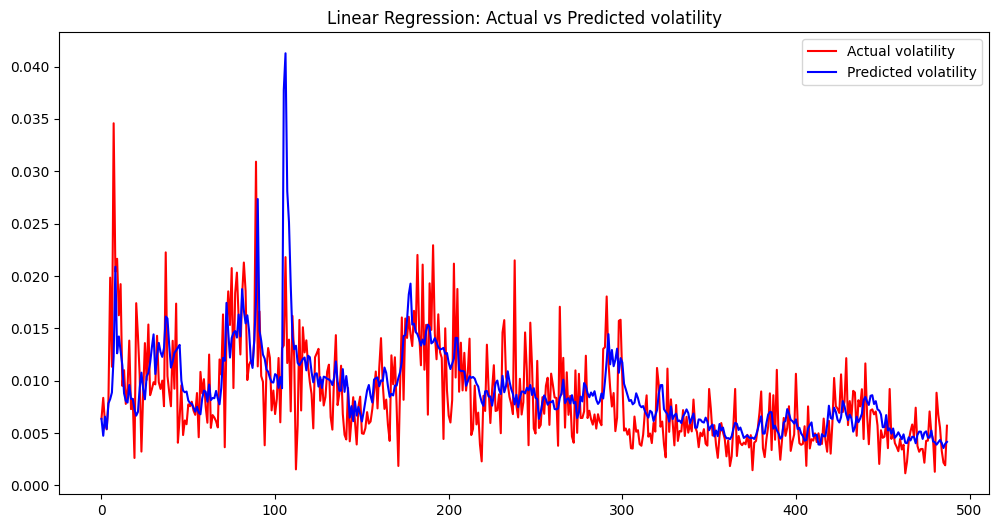

In [433]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, "red", label="Actual volatility")
plt.plot(y_pred_ols, "blue", label="Predicted volatility")
plt.title("Linear Regression: Actual vs Predicted volatility")
plt.legend()
plt.show()

In [ ]:
# Elastic Net
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("elastic_net", ElasticNet(random_state=42, max_iter=10000))
])

param_grid = {
    "elastic_net__alpha": np.arange(0.01, 10, 0.01),
    "elastic_net__l1_ratio": np.arange(0.1, 1, 0.1)
}

grid_search = GridSearchCV(
    pipe, param_grid, 
    cv=TimeSeriesSplit(n_splits=3),
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred_en = best_model.predict(X_test)

print("Elastic Net results:")
print(f"MSE: {mean_squared_error(y_test, y_pred_en):.6f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_en):.6f}")
print(f"R²:  {r2_score(y_test, y_pred_en):.4f}")
print(f"Parameters: {grid_search.best_params_}")

Elastic Net results:
MSE: 0.000013
MAE: 0.002585
R²:  0.4022
Parameters: {'elastic_net__alpha': np.float64(0.01), 'elastic_net__l1_ratio': np.float64(0.1)}


In [ ]:
# Which features did the Elastic Net model choose?
model = best_model.named_steps["elastic_net"]
importance = model.coef_
feature_importance = pd.Series(importance, index=X_train.columns)
feature_importance = feature_importance.sort_values(key=abs, ascending=False)
print(feature_importance)

VIX_lag1                   0.002759
bear market_lag1           0.000783
recession_lag1             0.000105
const                      0.000000
stock market crash_lag1    0.000000
bull market_lag1           0.000000
stock bubble_lag1         -0.000000
market volatility_lag1     0.000000
S&P 500_lag1               0.000000
interest rates_lag1        0.000000
inflation_lag1            -0.000000
financial crisis_lag1      0.000000
sentiment_lag1             0.000000
dtype: float64


In [ ]:
# Linear Regression using only VIX
X_vix = df_model["VIX_lag1"]
X_vix = pd.DataFrame(X_vix)
split = int(0.8 * len(X))
X_train_vix, X_test_vix = X_vix[:split], X_vix[split:]

ols_vix = LinearRegression()
ols_vix.fit(X_train_vix, y_train)
y_pred_vix = ols_vix.predict(X_test_vix)

mse = mean_squared_error(y_test, y_pred_vix)
mae = mean_absolute_error(y_test, y_pred_vix)
r2 = r2_score(y_test, y_pred_vix)

print("Linear Regression (only VIX) results:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²:  {r2:.4f}")

Linear Regression (only VIX) results:
MSE: 0.000012
MAE: 0.002533
R²:  0.4318


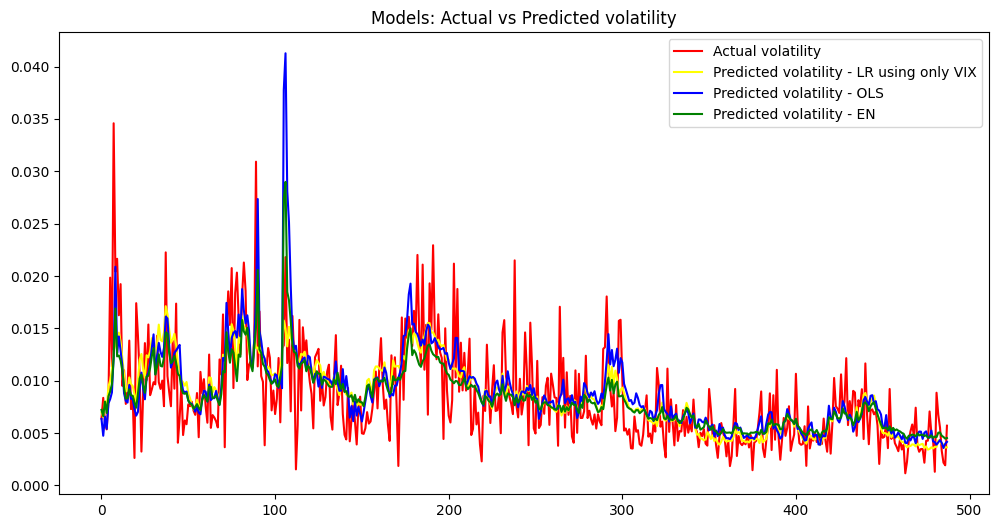

In [437]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, "red", label="Actual volatility")
plt.plot(y_pred_vix, "yellow", label="Predicted volatility - LR using only VIX")
plt.plot(y_pred_ols, "blue", label="Predicted volatility - OLS")
plt.plot(y_pred_en, "green", label="Predicted volatility - EN")

plt.title("Models: Actual vs Predicted volatility")
plt.legend()
plt.show()

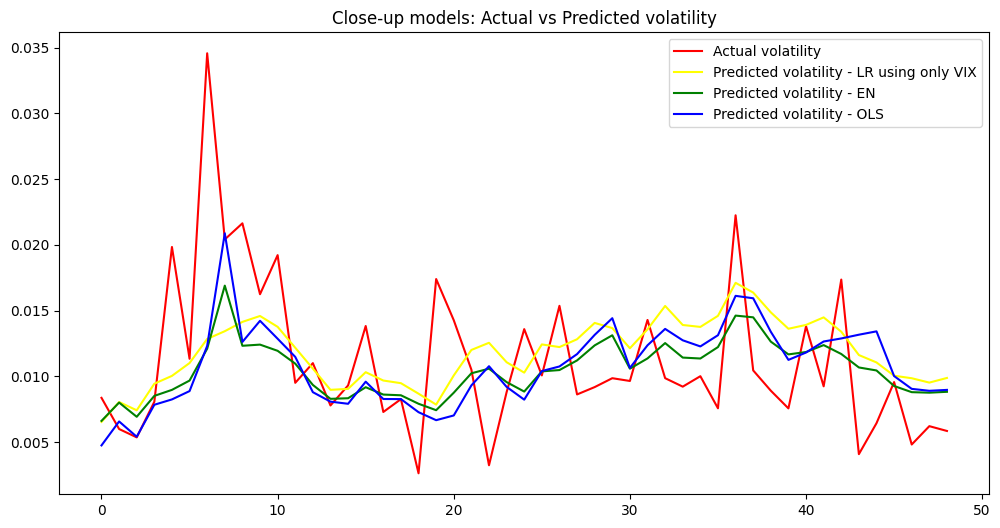

In [438]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[1:50], "red", label="Actual volatility")
plt.plot(y_pred_vix[1:50], "yellow", label="Predicted volatility - LR using only VIX")
plt.plot(y_pred_en[1:50], "green", label="Predicted volatility - EN")
plt.plot(y_pred_ols[1:50], "blue", label="Predicted volatility - OLS")

plt.title("Close-up models: Actual vs Predicted volatility")
plt.legend()
plt.show()